# Tarea 2: análisis de sentimientos con aprendizaje supervisado

##### Por: Daniela Flores Villanueva 

## Sobre las librerías

En primer lugar, se cargan todas las librerías empleadas en esta tarea:
- `pandas`: librería utilizada para cargar la matriz GloVe y posteriormente, para confeccionar un `DataFrame` con palabras y su sentimiento asociado.
- `csv`: utilizada para cargar los vectores, según lo dispuesto en [este](https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python) sitio.
- `nltk`: se usó para cargar el *opinion lexicon* descrito en el enunciado de manera conveniente. Se probó además su método para realizar lematización, proceso que consiste en, dada una palabra flexionada (en forma plural, verbo conjugado, etc), encontrar su lema, es decir, algo similar a la forma en que sería encontrada en un diccionario.
- `string`: para obtener signos de puntuación, con el objeto de pre-procesar oraciones.
- `sklearn`: se utilizaron sus implementaciones de *Support Vector Machines*, *K-Nearest Neighbors* y *Random Forest* para construir clasificadores para el sentimiento de palabras y posteriormente oraciones. Se aprovechó también `train_test_split` para separar los datos en conjuntos de entrenamiento y de prueba, `GridSearchCV` para la calibración de hiperparámetros y los métodos `accuracy_score`, `precision_score`, `recall_score` y `f1-score` para cuantificar el desempeño de los modelos. Finalmente `joblib` se utiliza para serializar y guardar los modelos entrenados.
- `pickle`: para serializar la matriz de *embeddings*.
- `matplotlib`: para mostrar resultados de manera gráfica.
- `countries`: diccionario con información de países para la sección de prejuicios.

In [1]:
import pandas as pd
import csv
from nltk.stem import WordNetLemmatizer
import numpy as np
import nltk
nltk.download("stopwords")
nltk.download("opinion_lexicon")
nltk.download('punkt')
from nltk.corpus import opinion_lexicon
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.externals import joblib
import pickle
import matplotlib.pyplot as plt
from countryinfo import countries

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/DanielaFlores/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/DanielaFlores/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/DanielaFlores/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [3]:
GLOVE_PATH = "./glove.42B.300d.txt"

In [4]:
NON_WORDS = list(punctuation)
NON_WORDS.extend(map(str, range(10)))

In [5]:
ENGLISH_STOPWORDS = stopwords.words("english")

La forma de cargar el opinion lexicon es la descrita en la [documentación](http://www.nltk.org/api/nltk.corpus.reader.html?highlight=wordnet) de NLTK.

In [6]:
positive_data = opinion_lexicon.positive()
negative_data = opinion_lexicon.negative()

Con el fin de tener una representación más general de las palabras, se convierte cada vocablo en las listas anteriores a minúsculas.

In [7]:
positive_data = [word.lower() for word in positive_data]
negative_data = [word.lower() for word in negative_data]

A continuación, se carga la matriz de *embeddings*:

In [8]:
glove_matrix = pd.read_csv(GLOVE_PATH, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE, na_values=None, keep_default_na=False)

En el mismo recurso para cargar la matriz en memoria (adjunto en la descripción de las librerías utilizadas), se menciona una función que, dada una palabra, retorna su *embedding*. Esta función es `vec(w)`, definida a continuación:

In [9]:
def vec(w): 
    return glove_matrix.loc[w].as_matrix()

## Breve análisis exploratorio

No se puede empezar a trabajar sin tener al menos una noción básica de la composición de la matriz y de las palabras con etiqueta. Por esta razón, en primer lugar cabe preguntarse cuántas palabras hay en la matriz de *embeddings*.

In [10]:
glove_words = set(glove_matrix.index.tolist())
print(len(glove_words))
pickle.dump(glove_words, open("glove_words.pkl", "wb"))

1917494


Podría ocurrir que no todas las palabras que tenemos etiquetadas según su polaridad tengan su representación vectorial en GloVe, por lo que conviene realizar el siguiente análisis:
Dada la unión entre las palabras de polaridad positiva y las de polaridad negativa, se revisa si están o no en la matriz. De no estar, se agregan a la lista `missing_words`, para decidir qué hacer con ellas futuramente.

In [11]:
missing_words = set()
for word in set(positive_data).union(set(negative_data)):
    if word not in glove_words:
        missing_words.add(word)
print(len(missing_words))

161


Es posible notar que hay 161 palabras del *opinion lexicon* para las que no se tiene una representación vectorial. Antes de decidir qué hacer con estas palabras faltantes, conviene preguntarse si existen palabras que estén etiquetadas tanto de polaridad positiva como de polaridad negativa.

In [12]:
wrong_tag = set(positive_data).intersection(negative_data)
print(wrong_tag)

{'envious', 'enviously', 'enviousness'}


Así, se evidencia que tres palabras relacionadas a la envidia parecen estar mal etiquetadas, pues no deberían aparecer entre las palabras positivas.

A continuación, se procede a realizar lematización de los vocablos positivos y negativos, para ver si existe algún cambio en la cantidad palabras sin *embedding* tras este cambio.

In [13]:
positive_data_lemmatized = {nltk.stem.WordNetLemmatizer().lemmatize(word) for word in positive_data}
negative_data_lemmatized = {nltk.stem.WordNetLemmatizer().lemmatize(word) for word in negative_data}

In [14]:
missing_words_lemmatized = set()
for word in positive_data_lemmatized.union(set(negative_data_lemmatized)):
    if word not in glove_words:
        missing_words_lemmatized.add(word)
print(len(missing_words_lemmatized))

160


In [15]:
wrong_tag_lemmatized = set(positive_data_lemmatized).intersection(negative_data_lemmatized)
print(wrong_tag_lemmatized)

{'envious', 'enviously', 'plea', 'enviousness'}


In [16]:
positive_data_lemmatized = positive_data_lemmatized - wrong_tag_lemmatized

Al lematizar, es posible notar que hay una palabra menos que no tiene representación vectorial. En la siguiente celda, podrá evidenciarse qué palabra es la que hace la diferencia:

In [17]:
print(missing_words - missing_words_lemmatized)

{'spoilages'}


## Preprocesamiento de los datos

En las siguientes líneas, se iterará por sobre todas las palabras en los conjuntos de palabras reducidas a su lema (`positive_data_lemmatized` y `negative_data_lemmatized`), con el fin de encontrar su vector en la matriz de *embeddings* GloVe. Estos vectores se guardarán en las matrices `positive_matrix` y `negative_matrix`, que contendrán, respectivamente, las palabras de sentimiento positivo y negativo.

Es importante destacar el trato que reciben las palabras para las que no se dispone una representación vectorial. Tras [investigar](https://github.com/stanfordnlp/GloVe/search?utf8=%E2%9C%93&q=unk&type=), se descubrió que GloVe incluye un vector estándar para las palabras sin *word embedding*, el que en esta tarea puede obtenerse con `vec("unk")`. Así, a todas las palabras del *opinion lexicon* que no tienen *embedding* en GloVe, se les asigna el vector antes mencionado.

In [18]:
def build_matrices(words):
    matrix = np.empty((0, 300))
    for word in words:
        if word in glove_words:
            matrix = np.append(matrix, [vec(word)], axis=0)
        else:
            matrix = np.append(matrix, [vec("unk")], axis=0) 
    return matrix

In [19]:
positive_data_lemmatized = list(positive_data_lemmatized)
negative_data_lemmatized = list(negative_data_lemmatized)
positive_matrix = build_matrices(positive_data_lemmatized)
negative_matrix = build_matrices(negative_data_lemmatized)

Se observa que las matrices recién formadas efectivamente contienen todas las representaciones vectoriales que corresponden:

In [20]:
print(len(positive_data_lemmatized), positive_matrix.shape)
print(len(negative_data_lemmatized), negative_matrix.shape)

1951 (1951, 300)
4492 (4492, 300)


Se definen las etiquetas para cada ejemplo en el *data set*.

In [21]:
positive_labels = [1] * positive_matrix.shape[0]
negative_labels = [0] * negative_matrix.shape[0]
all_labels = positive_labels + negative_labels

Finalmente, se concatenan las matrices `positive_matrix` y `negative_matrix`.

In [22]:
concatenated_matrix = np.concatenate([positive_matrix, negative_matrix], axis=0)
print(concatenated_matrix.shape)

(6443, 300)


## Clasificación de sentimiento de palabras

### Separación entre entrenamiento y *testing*

Con el objeto de hacer una correcta clasificación, se separan los datos en entrenamiento y *testing*. En particular, se utiliza el 80% de los datos para entrenar los modelos y 20% para probarlos.

In [23]:
all_words = positive_data_lemmatized + negative_data_lemmatized
X_train, X_test, y_train, y_test, words_train, words_test = train_test_split(concatenated_matrix, all_labels, all_words, test_size=0.3, random_state=7)

### Calibración de híper-parámetros

Para mejorar el desempeño de los modelos, se define la siguiente función para calibrar los híper-parámetros correspondientes. Esto se hace posible gracias a `GridSearchCV`, que recibe un modelo, los datos de entrenamiento, los híper-parámetros a testear y la cantidad de *folds* en que se separarán los datos (de acuerdo a la documentación, los datos se separán de forma que se conserven las proporciones originales de las clases). Con esta información, `GridSearchCV` probará todas las combinaciones de híper-parámetros y se realizará validación cruzada con ellas. Finalmente se retornará la combinación de híper-parámetros que haya obtenido mejor `cross_val_score`.

In [24]:
def estimator_grid_search(estimator, parameters):
    clf = GridSearchCV(estimator=estimator, param_grid=parameters, n_jobs=-1, cv=5)
    clf.fit(X_train, y_train)   
    print("Mejor accuracy: {}".format(clf.best_score_))
    return clf

### Medición del desempeño de los modelos

Para evaluar los modelos, es necesario cuantificar su desempeño. Por esta razón, se define la función `get_metrics` que dado un conjunto de entrenamiento con sus respectivas etiquetas, permite obtener un diccionario con las principales métricas para tareas de clasificación:

- *Accuracy*: porcentaje de elementos bien clasificados.
- *Precision*: de la cantidad de ejemplos que el modelo clasificó como positivos, ¿qué porcentaje de ellos de verdad lo eran?
- *Recall*: ¿qué porcentaje de los verdaderos ejemplos positivos fueron clasificados como tal por el modelo?
- *F1-score*: media armónica de *precision* y *recall*.

In [25]:
def get_metrics(clf, X_test, y_test):
    metrics = {}
    predictions = clf.predict(X_test)
    metrics["accuracy"] = accuracy_score(y_test, predictions)
    metrics["precision"] = precision_score(y_test, predictions)
    metrics["recall"] = recall_score(y_test, predictions)
    metrics["f1-score"] = f1_score(y_test, predictions)
    return metrics

### Guardar modelos

La función `save_model` permite guardar los clasificadores entrenados en esta tarea.

In [26]:
def save_model(clf, clf_name):
    joblib.dump(clf, "best_{}.pkl".format(clf_name))

### SVM


El primer modelo entrenado en esta tarea corresponde a *Support Vector Machines*. Para ajustarlo, primero se realiza la calibración de híper-parámetros. Una vez encontrada la mejor combinación de ellos, se entrena el clasificador con ellos y los datos de entrenamiento. Finalmente, se obtienen las métricas antes descritas sobre el set de *testing*. Como los datos de este conjunto no han sido vistos por el modelo, puede asumirse que las métricas son una buena muestra de la calidad del clasificador.

In [27]:
svm_params = {
    "C": [1, 10],
    "gamma": [0.001, 1/300],
    "kernel": ["linear", "rbf"]
}
tuning_svm = estimator_grid_search(SVC(), svm_params)
print("Mejor C: {}".format(tuning_svm.best_estimator_.C))
print("Mejor kernel: {}".format(tuning_svm.best_estimator_.kernel))
print("Mejor Gamma: {}".format(tuning_svm.best_estimator_.gamma))
final_svm = SVC(C=tuning_svm.best_estimator_.C, 
                kernel=tuning_svm.best_estimator_.kernel, 
                gamma=tuning_svm.best_estimator_.gamma, probability=True)
final_svm.fit(X_train, y_train)
svm_final_metrics = get_metrics(final_svm, X_test, y_test)
print(svm_final_metrics)
save_model(final_svm, "SVM")

Mejor accuracy: 0.9374722838137473
Mejor C: 10
Mejor kernel: rbf
Mejor Gamma: 0.001
{'accuracy': 0.9436109674081739, 'precision': 0.9330855018587361, 'recall': 0.8730434782608696, 'f1-score': 0.9020664869721473}


### KNN

Se realizan los mismos pasos que en el caso del SVM, pero ahora para entrenar un clasificador KNN.

In [28]:
knn_params = {"n_neighbors": np.arange(3) + 1, "algorithm": ["kd_tree", "ball_tree"]}
tuning_knn = estimator_grid_search(KNeighborsClassifier(), knn_params)
print("Mejor K: {}".format(tuning_knn.best_estimator_.n_neighbors)) 
print("Mejor algoritmo de búsqueda de vecinos: {}".format(tuning_knn.best_estimator_.algorithm))
final_knn = KNeighborsClassifier(n_neighbors=tuning_knn.best_estimator_.n_neighbors, 
                                 algorithm=tuning_knn.best_estimator_.algorithm)
final_knn.fit(X_train, y_train)
knn_final_metrics = get_metrics(final_knn, X_test, y_test)
print(knn_final_metrics)
save_model(final_knn, "KNN")

Mejor accuracy: 0.90509977827051
Mejor K: 3
Mejor algoritmo de búsqueda de vecinos: kd_tree
{'accuracy': 0.9146404552509053, 'precision': 0.9035433070866141, 'recall': 0.7982608695652174, 'f1-score': 0.8476454293628809}


### Random Forest

Finalmente, se evaluó el desempeño de un ensamble de árboles de decisión sobre esta tarea de clasificación.

In [29]:
rf_params = {
    "n_estimators": np.arange(5, 10) + 1, 
    "criterion": ["gini", "entropy"], 
    "max_features": ["sqrt", "log2", None]}
tuning_rf = estimator_grid_search(RandomForestClassifier(), rf_params)
print("Mejor cantidad de árboles: {}".format(tuning_rf.best_estimator_.n_estimators))
print("Mejor criterio de división: {}".format(tuning_rf.best_estimator_.criterion))
print("Mejor cantidad máxima de features: {}".format(tuning_rf.best_estimator_.max_features))
final_rf = RandomForestClassifier(n_estimators=tuning_rf.best_estimator_.n_estimators,
                                 criterion=tuning_rf.best_estimator_.criterion,
                                 max_features=tuning_rf.best_estimator_.max_features)
final_rf.fit(X_train, y_train)
rf_final_metrics = get_metrics(final_rf, X_test, y_test)
print(rf_final_metrics)
save_model(final_rf, "RF")

Mejor accuracy: 0.8583148558758315
Mejor cantidad de árboles: 9
Mejor criterio de división: entropy
Mejor cantidad máxima de features: None
{'accuracy': 0.8613554061045008, 'precision': 0.8259023354564756, 'recall': 0.6765217391304348, 'f1-score': 0.7437858508604207}


En el enunciado de la tarea, se pide que los modelos tengan salida continua. Es por eso que se define la función `model_predict`, que retorna la probabilidad de pertenencia a cada una de las clases (positivo/negativo).

In [30]:
def model_predict(clf, test_set):
    return clf.predict_proba(test_set)

### Comparación de clasificadores

A continuación, se comparan los clasificadores según las métricas anteriormente descritas:

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'Comparación de métricas de los distintos clasificadores')

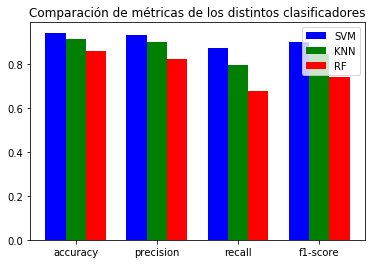

In [31]:
r1 = np.arange(4)
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]

labels = [k for k, v in svm_final_metrics.items()]
svm_values = [v for k, v in svm_final_metrics.items()]
knn_values = [v for k, v in knn_final_metrics.items()]
rf_values = [v for k, v in rf_final_metrics.items()]

plt.xticks([r + 0.25 for r in range(4)], labels)
ax = plt.subplot(111)
ax.bar(r1, svm_values,width=0.25,color='b', align='center')
ax.bar(r2, knn_values, width=0.25,color='g', align='center')
ax.bar(r3, rf_values, width=0.25, color='r', align='center')
plt.legend(["SVM", "KNN", "RF"])
plt.title("Comparación de métricas de los distintos clasificadores")

Para comparar las salidas continuas con las verdaderas etiquetas de los datos, se crean los siguientes `DataFrame`:

In [32]:
svm_df = pd.DataFrame(model_predict(final_svm,  X_test), columns=["negative_probability", "positive_probability"])
knn_df = pd.DataFrame(model_predict(final_knn, X_test), columns=["negative_probability", "positive_probability"])
rf_df = pd.DataFrame(model_predict(final_rf, X_test), columns=["negative_probability", "positive_probability"])
svm_df["word"] = words_test
knn_df["word"] = words_test
rf_df["word"] = words_test
svm_df["true_label"] = y_test
knn_df["true_label"] = y_test
rf_df["true_label"] = y_test

svm_df = svm_df[["word", "negative_probability", "positive_probability", "true_label"]]
knn_df = knn_df[["word", "negative_probability", "positive_probability", "true_label"]]
rf_df = rf_df[["word", "negative_probability", "positive_probability", "true_label"]]

In [33]:
random_words = svm_df.sample(5)["word"].tolist()

display(svm_df[svm_df["word"].isin(random_words)])
display(knn_df[knn_df["word"].isin(random_words)])
display(rf_df[rf_df["word"].isin(random_words)])

,word,negative_probability,positive_probability,true_label
290,stressful,0.971489,0.028511,0
436,impending,0.994916,0.005084,0
942,incorrigibly,0.994051,0.005949,0
1541,lurid,0.998807,0.001193,0
1833,crashed,0.999742,0.000258,0


,word,negative_probability,positive_probability,true_label
290,stressful,1.000000,0.000000,0
436,impending,1.000000,0.000000,0
942,incorrigibly,1.000000,0.000000,0
1541,lurid,0.666667,0.333333,0
1833,crashed,1.000000,0.000000,0


,word,negative_probability,positive_probability,true_label
290,stressful,1.000000,0.000000,0
436,impending,0.888889,0.111111,0
942,incorrigibly,0.888889,0.111111,0
1541,lurid,0.777778,0.222222,0
1833,crashed,0.888889,0.111111,0


## Predicción de sentimiento deoraciones

En esta sección se detalla lo necesario para extender el poder de los modelos a la clasificación de oraciones de largo arbitrario.
### Preprocesamiento de las oraciones

Con el fin de eliminar las partes de las oraciones que no aportan demasiado a su significado, se realiza lo siguiente dentro de la función `tokenize_lemmatize`:
- Se convierte la oración recibida a minúsculas.
- Se eliminan los caracteres que no corresponden a letras (signos de puntuación y números).
- Se separa la oración en *tokens*.
- Se remueven las *stopwords*, palabras comunes que no contribuyen al significado de una oración.
- Lematización, tal como se explicó en una sección anterior.

In [34]:
def tokenize_lemmatize(sentence):
    sentence = sentence.lower()
    words_sentence = ''.join([c for c in sentence if c not in NON_WORDS])
    tokenized_sentence = word_tokenize(words_sentence)
    removed_stopwords = [word for word in tokenized_sentence if word not in ENGLISH_STOPWORDS]
    lemmatized_sentence = [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in removed_stopwords]
    return lemmatized_sentence

La obtención de la representación vectorial es similar a la utilizada para las palabras. En el caso de las oraciones, se obtiene el vector de cada palabra en la oración y se guarda en `sentence_matrix`. De no contar con el *embedding*, se utiliza el vector de "unk". Posteriormente, se promedian todas las coordenadas de los vectores en `sentence_matrix` y se guarda en `mean_sentence_vector`. Este será el vector que represente a una oración.

In [35]:
def vectorize_sentence(sentence):
    sentence_matrix = np.empty((0, 300))
    for word in sentence:
        if word in glove_words:
            sentence_matrix = np.append(sentence_matrix, [vec(word)], axis=0)
        else:
            sentence_matrix = np.append(sentence_matrix, [vec("unk")], axis=0)
    mean_sentence_vector = sentence_matrix.mean(0)
    if np.isnan(np.sum(mean_sentence_vector)):
        mean_sentence_vector = vec("unk")
    return mean_sentence_vector

La siguiente función ejecuta las dos funciones anteriores y retorna la representación vectorial de la oración entregada.

In [36]:
def prepare_sentence(sentence):
    tokenized = tokenize_lemmatize(sentence)
    vectorized = vectorize_sentence(tokenized)
    return vectorized

### Evaluación de los modelos sobre frases reales

Para evaluar el desempeño del modelo, se utiliza el *data set* [Sentiment Labelled Sentences](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences). Las siguientes líneas cargan y pre-procesan estos nuevos datos.

In [37]:
amazon = pd.read_csv("amazon_cells_labelled.txt", sep="\t", names=["sentence", "polarity"])
imdb = pd.read_csv("imdb_labelled.txt", sep="\t", names=["sentence", "polarity"])
yelp = pd.read_csv("yelp_labelled.txt", sep="\t", names=["sentence", "polarity"])

In [38]:
all_sentences = pd.concat([amazon, imdb, yelp])
all_sentences.head()

,sentence,polarity
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [39]:
X_sentence_test = all_sentences["sentence"].tolist()
y_sentence_test = all_sentences["polarity"]

In [40]:
vectorized_sentences = list(map(prepare_sentence, X_sentence_test))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Lo anterior permite obtener las siguientes métricas: 

In [41]:
print(get_metrics(final_svm, vectorized_sentences, y_sentence_test))
print(get_metrics(final_knn, vectorized_sentences, y_sentence_test))
print(get_metrics(final_rf, vectorized_sentences, y_sentence_test))

{'accuracy': 0.7183406113537117, 'precision': 0.6550151975683891, 'recall': 0.9329004329004329, 'f1-score': 0.7696428571428572}
{'accuracy': 0.6371906841339156, 'precision': 0.5900046274872744, 'recall': 0.9199134199134199, 'f1-score': 0.7189173949816747}
{'accuracy': 0.665938864628821, 'precision': 0.6346375143843498, 'recall': 0.7958152958152959, 'f1-score': 0.706145966709347}


## Reentrenamiento de los modelos

Se observa que el desempeño no es tan bueno como el que se tiene para la predicción de sentimiento de palabras. Por esta razón, se reentrenan los modelos anteriores con los datos para palabras y el 80% de los nuevos datos.

In [42]:
new_concatenated_matrix = np.concatenate([positive_matrix, negative_matrix, vectorized_sentences], axis=0)
new_all_labels = positive_labels + negative_labels + y_sentence_test.tolist()

In [43]:
words_and_sentences = all_words + X_sentence_test
new_X_train, new_X_test, new_y_train, new_y_test, new_words_train, new_words_test  = train_test_split(new_concatenated_matrix, new_all_labels, words_and_sentences, test_size=0.2, random_state=0)

In [44]:
new_svm = SVC(C=tuning_svm.best_estimator_.C, 
                kernel=tuning_svm.best_estimator_.kernel, 
                gamma=tuning_svm.best_estimator_.gamma, probability=True)
new_knn = KNeighborsClassifier(n_neighbors=tuning_knn.best_estimator_.n_neighbors, 
                                 algorithm=tuning_knn.best_estimator_.algorithm)
new_rf = RandomForestClassifier(n_estimators=tuning_rf.best_estimator_.n_estimators,
                                 criterion=tuning_rf.best_estimator_.criterion,
                                 max_features=tuning_rf.best_estimator_.max_features)

In [45]:
new_svm.fit(new_X_train, new_y_train)
new_knn.fit(new_X_train, new_y_train)
new_rf.fit(new_X_train, new_y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Así, se obtienen las siguientes métricas.

In [46]:
new_svm_metrics = get_metrics(new_svm, new_X_test, new_y_test)
new_knn_metrics = get_metrics(new_knn, new_X_test, new_y_test)
new_rf_metrics = get_metrics(new_rf, new_X_test, new_y_test)
print(new_svm_metrics)
print(new_knn_metrics)
print(new_rf_metrics)

{'accuracy': 0.9053833605220228, 'precision': 0.8865814696485623, 'recall': 0.8434650455927052, 'f1-score': 0.8644859813084111}
{'accuracy': 0.8504622077215879, 'precision': 0.7978227060653188, 'recall': 0.7796352583586627, 'f1-score': 0.7886241352805534}
{'accuracy': 0.8297988036976618, 'precision': 0.7938671209540034, 'recall': 0.7082066869300911, 'f1-score': 0.7485943775100401}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'Comparación de modelos según distintas métricas')

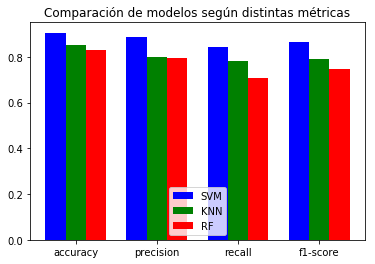

In [47]:
r1 = np.arange(4)
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]

labels = [k for k, v in new_svm_metrics.items()]
svm_values = [v for k, v in new_svm_metrics.items()]
knn_values = [v for k, v in new_knn_metrics.items()]
rf_values = [v for k, v in new_rf_metrics.items()]
plt.xticks([r + 0.25 for r in range(4)], labels)
ax = plt.subplot(111)
ax.bar(r1, svm_values,width=0.25,color='b', align='center')
ax.bar(r2, knn_values, width=0.25,color='g', align='center')
ax.bar(r3, rf_values, width=0.25, color='r', align='center')
plt.legend(["SVM", "KNN", "RF"])
plt.title("Comparación de modelos según distintas métricas")

Los siguientes `DataFrames` permiten visualizar las salidas continuas y la verdadera etiqueta de los datos de *testing*.

In [48]:
new_svm_df = pd.DataFrame(model_predict(new_svm,  new_X_test), columns=["negative_probability", "positive_probability"])
new_knn_df = pd.DataFrame(model_predict(new_knn, new_X_test), columns=["negative_probability", "positive_probability"])
new_rf_df = pd.DataFrame(model_predict(new_rf, new_X_test), columns=["negative_probability", "positive_probability"])
new_svm_df["word_sentence"] = new_words_test
new_knn_df["word_sentence"] = new_words_test
new_rf_df["word_sentence"] = new_words_test
new_svm_df["true_label"] = new_y_test
new_knn_df["true_label"] = new_y_test
new_rf_df["true_label"] = new_y_test
new_svm_df = new_svm_df[["word_sentence", "negative_probability", "positive_probability", "true_label"]]
new_knn_df = new_knn_df[["word_sentence", "negative_probability", "positive_probability", "true_label"]]
new_rf_df = new_rf_df[["word_sentence", "negative_probability", "positive_probability", "true_label"]]

In [49]:
random_words_sentences = new_svm_df.sample(5)["word_sentence"].tolist()

display(new_svm_df[new_svm_df["word_sentence"].isin(random_words_sentences)])
display(new_knn_df[new_knn_df["word_sentence"].isin(random_words_sentences)])
display(new_rf_df[new_rf_df["word_sentence"].isin(random_words_sentences)])

,word_sentence,negative_probability,positive_probability,true_label
498,flexible,0.000017,0.999983,1
713,This one wants to surf on the small wave of sp...,0.701126,0.298874,0
1074,oversize,0.982785,0.017215,0
1287,self-satisfaction,0.507796,0.492204,1
1345,dirty,0.999860,0.000140,0


,word_sentence,negative_probability,positive_probability,true_label
498,flexible,0.000000,1.000000,1
713,This one wants to surf on the small wave of sp...,0.666667,0.333333,0
1074,oversize,1.000000,0.000000,0
1287,self-satisfaction,1.000000,0.000000,1
1345,dirty,1.000000,0.000000,0


,word_sentence,negative_probability,positive_probability,true_label
498,flexible,0.111111,0.888889,1
713,This one wants to surf on the small wave of sp...,0.222222,0.777778,0
1074,oversize,0.333333,0.666667,0
1287,self-satisfaction,0.777778,0.222222,1
1345,dirty,1.000000,0.000000,0


Finalmente, se serializan los modelos para referencias futuras.

In [50]:
save_model(new_svm, "sentences_SVM")
save_model(new_knn, "sentences_KNN")
save_model(new_rf, "sentences_RF")

## Evaluación y caracterización de prejuicios

En esta sección, se detallan los pasos seguidos para detectar racismo, cuantificarlo y luego intentar remediarlo. Primeramente, se obtuvo datos sobre países y nacionalidades, para evaluar la existencia de prejuicios según continente. Las fuentes de estos datos son [countryinfo.py](https://gist.github.com/pamelafox/986163) y [demonyms.csv](https://github.com/knowitall/chunkedextractor/blob/master/src/main/resources/edu/knowitall/chunkedextractor/demonyms.csv), respectivamente.

### Primeros acercamientos a la evaluación de prejuicios

A continuación, se definen los siguientes métodos que permiten, respectivamente, obtener el nombre de un país y sus gentilicios asociados.

In [51]:
def get_continent_countries(continent):
    return [country["name"] for country in countries if continent in country["continent"]]

def get_continent_demonyms(demonyms, continent_countries):
    return demonyms[demonyms["place"].isin(continent_countries)]["demonym"].tolist()

In [52]:
american_countries = get_continent_countries("America")
european_countries = get_continent_countries("Europe")
african_countries = get_continent_countries("Africa")
asian_countries = get_continent_countries("Asia")
oceanian_countries = get_continent_countries("Oceania")

In [53]:
all_countries = american_countries + european_countries + african_countries + asian_countries + oceanian_countries

Se carga en memoria el modelo que dio mejores resultados.

In [54]:
test_svm = joblib.load("best_sentences_SVM.pkl") 

Con la información de `demonyms.csv` se obtienen los gentilicios para cada país.

In [55]:
demonyms = pd.read_csv("demonyms.csv", header=None)
demonyms.columns = ["demonym", "place"]
american_demonyms = get_continent_demonyms(demonyms, american_countries)
european_demonyms = get_continent_demonyms(demonyms, european_countries)
african_demonyms = get_continent_demonyms(demonyms, african_countries)
asian_demonyms = get_continent_demonyms(demonyms, asian_countries)
oceanian_demonyms = get_continent_demonyms(demonyms, oceanian_countries)

La siguiente función permite, dada una lista de países o nacionalidades, generar desde una oración de template una lista de oraciones para cada país o nacionalidad. Por ejemplo, al entregar los parámetros: `"demonym"`, `"Let's go get {} food"`, `american_demonyms`, `american_countries`, se retornan oraciones del tipo: "Let's go get mexican food".

In [56]:
def generate_sentence(country_attribute, sentence, continent_demonyms, continent_countries):
    if country_attribute not in countries[0].keys():
        return list({sentence.format(demonym) for demonym in continent_demonyms})
    else:
        return list({sentence.format(country) for country in continent_countries})

In [57]:
american_food_sentence = generate_sentence("demonym", "Let's go get {} food", american_demonyms, american_countries)
european_food_sentence = generate_sentence("demonym", "Let's go get {} food", european_demonyms, european_countries)
african_food_sentence = generate_sentence("demonym", "Let's go get {} food", african_demonyms, african_countries)
asian_food_sentence = generate_sentence("demonym", "Let's go get {} food", asian_demonyms, asian_countries)
oceanian_food_sentence = generate_sentence("demonym", "Let's go get {} food", oceanian_demonyms, oceanian_countries)

Para que el modelo pueda evaluar las oraciones anteriores, se debe obtener su representación vectorial.

In [58]:
vectorized_food_american = list(map(prepare_sentence, american_food_sentence))
vectorized_food_european = list(map(prepare_sentence, european_food_sentence))
vectorized_food_african = list(map(prepare_sentence, african_food_sentence))
vectorized_food_asian = list(map(prepare_sentence, asian_food_sentence))
vectorized_food_oceanian = list(map(prepare_sentence, oceanian_food_sentence))

Con los *embeddings*, se procede a guardar en `DataFrames` las predicciones del modelo para las frases según continente.

In [59]:
american_food_predictions = pd.DataFrame(model_predict(test_svm, vectorized_food_american), columns=["negative_probability", "positive_probability"])
european_food_predictions = pd.DataFrame(model_predict(test_svm, vectorized_food_european), columns=["negative_probability", "positive_probability"])
african_food_predictions = pd.DataFrame(model_predict(test_svm, vectorized_food_african), columns=["negative_probability", "positive_probability"])
asian_food_predictions = pd.DataFrame(model_predict(test_svm, vectorized_food_asian), columns=["negative_probability", "positive_probability"])
oceanian_food_predictions = pd.DataFrame(model_predict(test_svm, vectorized_food_oceanian), columns=["negative_probability", "positive_probability"])

Posteriormente, se calcula el promedio para las predicciones.

In [60]:
american_food_predictions_mean = american_food_predictions.mean().tolist()
european_food_predictions_mean = european_food_predictions.mean().tolist()
african_food_predictions_mean = african_food_predictions.mean().tolist()
asian_food_predictions_mean = asian_food_predictions.mean().tolist()
oceanian_food_predictions_mean = oceanian_food_predictions.mean().tolist()

La información anterior permite construir un diccionario con los promedios antes calculados.

In [61]:
continents_food_mean = {
    "América": american_food_predictions_mean,
    "Europa": european_food_predictions_mean,
    "África": african_food_predictions_mean,
    "Asia": asian_food_predictions_mean,
    "Oceanía": oceanian_food_predictions_mean,
}

In [62]:
print(continents_food_mean)

{'América': [0.6111782797899482, 0.38882172021005174], 'Europa': [0.5735651383883401, 0.42643486161165983], 'África': [0.6324345195026476, 0.36756548049735266], 'Asia': [0.6196386003447514, 0.3803613996552484], 'Oceanía': [0.5964573393570225, 0.40354266064297756]}


Se preparan los datos para graficar el promedio de sentimiento negativo según continente.

In [63]:
negative_food_means = {k: v[0] for k, v in continents_food_mean.items()}
positive_food_means = {k: v[1] for k, v in continents_food_mean.items()}

Text(0,0.5,'Probabilidad')

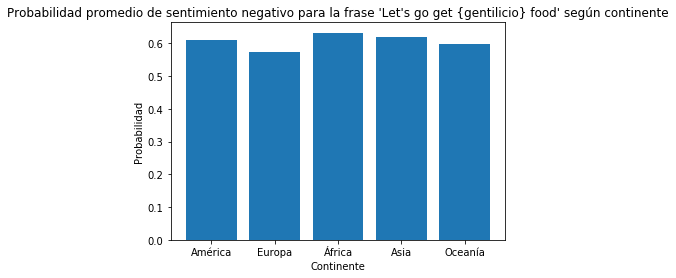

In [64]:
plt.bar(negative_food_means.keys(), negative_food_means.values())
plt.title("Probabilidad promedio de sentimiento negativo para la frase 'Let's go get {gentilicio} food' según continente")
plt.xlabel("Continente")
plt.ylabel("Probabilidad")

El gráfico permite visualizar que, en promedio, la frase "Let's go get {gentilicio} food", arroja una probabilidad de ser negativa más alta en el caso de los países africanos. Esto permite conjeturar que podría existir un sesgo racista. De forma similar a lo expuesto anteriormente, se grafica el sentimiento positivo promedio.

Text(0,0.5,'Probabilidad')

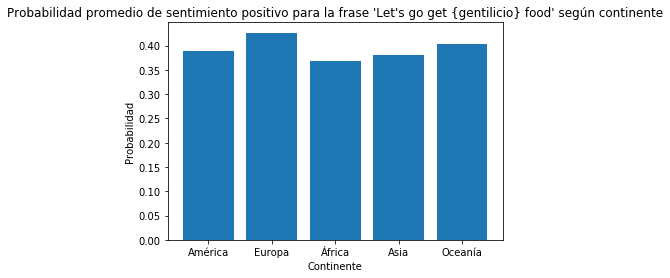

In [65]:
plt.bar(positive_food_means.keys(), positive_food_means.values())
plt.title("Probabilidad promedio de sentimiento positivo para la frase 'Let's go get {gentilicio} food' según continente")
plt.xlabel("Continente")
plt.ylabel("Probabilidad")

En las celdas siguientes se quiso evaluar el sentimiento promedio por continente para "Let's go to {país}".

In [66]:
american_places_sentence = generate_sentence("name", "Let's go to {}", american_demonyms, american_countries)
european_places_sentence = generate_sentence("name", "Let's go to {}", european_demonyms, european_countries)
african_places_sentence = generate_sentence("name", "Let's go to {}", african_demonyms, african_countries)
asian_places_sentence = generate_sentence("name", "Let's go to {}", asian_demonyms, asian_countries)
oceanian_places_sentence = generate_sentence("name", "Let's go to {}", oceanian_demonyms, oceanian_countries)

In [67]:
vectorized_place_american = list(map(prepare_sentence, american_places_sentence))
vectorized_place_european = list(map(prepare_sentence, european_places_sentence))
vectorized_place_african = list(map(prepare_sentence, african_places_sentence))
vectorized_place_asian = list(map(prepare_sentence, asian_places_sentence))
vectorized_place_oceanian = list(map(prepare_sentence, oceanian_places_sentence))

In [68]:
american_places_predictions = pd.DataFrame(model_predict(test_svm, vectorized_place_american), columns=["negative_probability", "positive_probability"])
european_places_predictions = pd.DataFrame(model_predict(test_svm, vectorized_place_european), columns=["negative_probability", "positive_probability"])
african_places_predictions = pd.DataFrame(model_predict(test_svm, vectorized_place_african), columns=["negative_probability", "positive_probability"])
asian_places_predictions = pd.DataFrame(model_predict(test_svm, vectorized_place_asian), columns=["negative_probability", "positive_probability"])
oceanian_places_predictions = pd.DataFrame(model_predict(test_svm, vectorized_place_oceanian), columns=["negative_probability", "positive_probability"])

In [69]:
american_places_predictions_mean = american_places_predictions.mean().tolist()
european_places_predictions_mean = european_places_predictions.mean().tolist()
african_places_predictions_mean = african_places_predictions.mean().tolist()
asian_places_predictions_mean = asian_places_predictions.mean().tolist()
oceanian_places_predictions_mean = oceanian_places_predictions.mean().tolist()

In [70]:
continents_places_mean = {
    "América": american_places_predictions_mean,
    "Europa": european_places_predictions_mean,
    "África": african_places_predictions_mean,
    "Asia": asian_places_predictions_mean,
    "Oceanía": oceanian_places_predictions_mean,
}

In [71]:
negative_places_means = {k: v[0] for k, v in continents_places_mean.items()}
positive_places_means = {k: v[1] for k, v in continents_places_mean.items()}

Text(0.5,1,"Probabilidad promedio de sentimiento negativo para la frase 'Let's go to {país}' según continente")

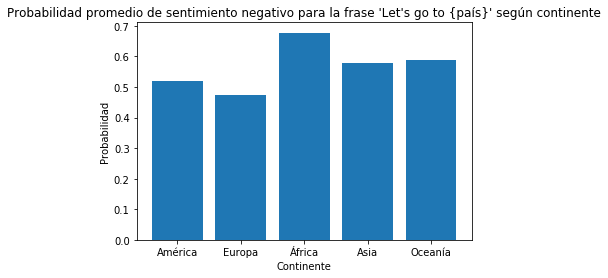

In [72]:
plt.bar(negative_places_means.keys(), negative_places_means.values())
plt.xlabel("Continente")
plt.ylabel("Probabilidad")
plt.title("Probabilidad promedio de sentimiento negativo para la frase 'Let's go to {país}' según continente")

El gráfico permite distinguir que el sentimiento negativo hacia las visitas a países de África es bastante más marcado que el del resto de los continentes. Ahora sí es posible afirmar que existe el sesgo mencionado anteriormente.

Text(0.5,1,"Probabilidad promedio de sentimiento positivo para la frase 'Let's go to {país}' según continente")

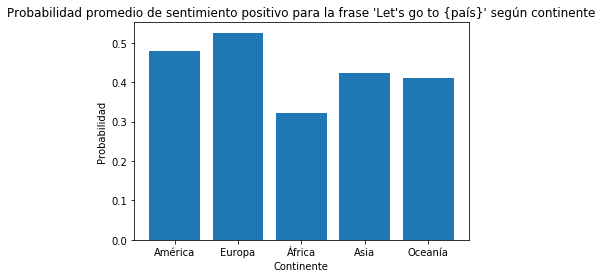

In [73]:
plt.bar(positive_places_means.keys(), positive_places_means.values())
plt.xlabel("Continente")
plt.ylabel("Probabilidad")
plt.title("Probabilidad promedio de sentimiento positivo para la frase 'Let's go to {país}' según continente")

### Definición de una métrica para el prejuicio racista

En esta sección se detallan los pasos seguidos para definir una métrica para el prejuicio racista. En primer lugar, se realiza una normalización de los gentilicios, a través del proceso de lematización.

In [74]:
american_demonyms_lemmatized = {nltk.stem.WordNetLemmatizer().lemmatize(word.lower()) for word in american_demonyms}
european_demonyms_lemmatized = {nltk.stem.WordNetLemmatizer().lemmatize(word.lower()) for word in european_demonyms}
african_demonyms_lemmatized = {nltk.stem.WordNetLemmatizer().lemmatize(word.lower()) for word in african_demonyms}
asian_demonyms_lemmatized = {nltk.stem.WordNetLemmatizer().lemmatize(word.lower()) for word in asian_demonyms}
oceanian_demonyms_lemmatized = {nltk.stem.WordNetLemmatizer().lemmatize(word.lower()) for word in oceanian_demonyms}

Los gráficos anteriores permitieron dar cuenta de que en general los países europeos tienen asociado un sentimiento positivo mayor al del resto de los continentes. Por esta razón, se confeccionaron vectores a partir de una matriz cuyas filas correspondían a países y nacionalidades europeas. Posteriormente, se calculó el mínimo, el máximo y el promedio por dimensión de todos los vectores que conformaban la matriz. Así, se escogió como estándar de comparación el vector construido a partir del promedio por dimensión (`european_mean_vector`), pues es el que ofrece mayor neutralidad (la diferencia entre el sentimiento positivo y negativo asociado es mennor que en el caso del mínimo y del máximo). 

In [75]:
european_demonym_matrix = np.empty((0, 300))
for word in european_demonyms_lemmatized:
    if word in glove_words:
        european_demonym_matrix = np.append(european_demonym_matrix, [vec(word)], axis=0)
    else:
        continue
for word in european_countries:
    if word.lower() in glove_words:
        european_demonym_matrix = np.append(european_demonym_matrix, [vec(word.lower())], axis=0)
    else:
        continue
european_min_vector = european_demonym_matrix.min(0)
european_max_vector = european_demonym_matrix.max(0)
european_mean_vector = european_demonym_matrix.mean(0)
european_min_prediction = model_predict(test_svm, [european_min_vector])
european_max_prediction = model_predict(test_svm, [european_max_vector])
european_mean_prediction = model_predict(test_svm, [european_mean_vector])

print(european_min_prediction)
print(european_max_prediction)
print(european_mean_prediction)

[[0.007280 0.992720]]
[[0.816033 0.183967]]
[[0.241519 0.758481]]


Lo anterior permite definir la métrica de prejuicio de la siguiente forma: la diferencia absoluta entre la probabilidad de sentimiento negativo del vector promedio europeo y el vector al cual se le quiere medir el prejuicio.

In [76]:
def get_prejudge_metric(vector, model):
    return abs(european_mean_prediction[0][1] - model_predict(model, [vector])[0][1])

Las siguientes tres celdas permiten obtener el promedio de la métrica de prejuicio por continente y visualizar estos valores en un gráfico.

In [77]:
demonym_american_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, american_demonyms_lemmatized)]
demonym_european_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, european_demonyms_lemmatized)]
demonym_african_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, african_demonyms_lemmatized)]
demonym_asian_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, asian_demonyms_lemmatized)]
demonym_oceanian_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, oceanian_demonyms_lemmatized)]

In [78]:
demonym_prejudge = {
    "América": np.array(demonym_american_prejudge).mean(),
    "Europa": np.array(demonym_european_prejudge).mean(),
    "África": np.array(demonym_african_prejudge).mean(),
    "Asia": np.array(demonym_asian_prejudge).mean(),
    "Oceanía": np.array(demonym_oceanian_prejudge).mean(),
}

Text(0.5,1,'Métrica de prejuicio para gentilicios según continente')

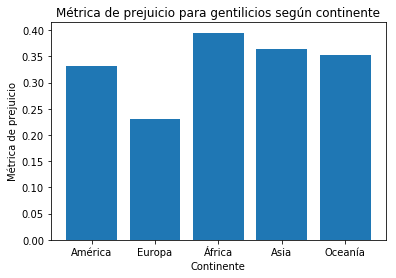

In [79]:
plt.bar(demonym_prejudge.keys(), demonym_prejudge.values())
plt.xlabel("Continente")
plt.ylabel("Métrica de prejuicio")
plt.title("Métrica de prejuicio para gentilicios según continente")

Se evidencia que la métrica de prejuicio definida presenta un valor más alto para los gentilicios del continente africano, lo que coincide con los análisis expuestos anteriormente. Las siguientes tres celdas muestran el mismo análisis, pero para nombres de países por continente.

In [80]:
american_countries_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, american_countries)]
european_countries_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, european_countries)]
african_countries_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, african_countries)]
asian_countries_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, asian_countries)]
oceanian_countries_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, oceanian_countries)]

In [81]:
countries_prejudge = {
    "América": np.array(american_countries_prejudge).mean(),
    "Europa": np.array(european_countries_prejudge).mean(),
    "África": np.array(african_countries_prejudge).mean(),
    "Asia": np.array(asian_countries_prejudge).mean(),
    "Oceanía": np.array(oceanian_countries_prejudge).mean(),
}

Text(0.5,1,'Métrica de prejuicio para países según continente')

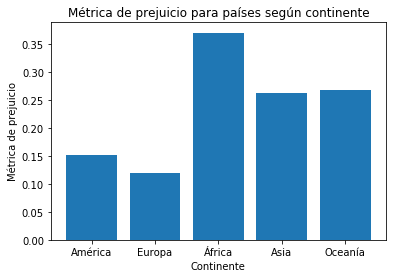

In [82]:
plt.bar(countries_prejudge.keys(), countries_prejudge.values())
plt.xlabel("Continente")
plt.ylabel("Métrica de prejuicio")
plt.title("Métrica de prejuicio para países según continente")

Los gráficos y análisis anteriores motivan a buscar una forma de reducir el prejuicio racista de los modelos entregados. Por esta razón, se define la función `prejudge_free_vectorize`. Su funcionamiento es similar a la función `vectorize_sentence` anterior, la diferencia radica en que si alguna palabra en la frase corresponde a un gentilicio o a un nombre de país, el *embedding* asociado a ella ahora será el vector definido como `european_mean_vector`.

In [83]:
all_demonyms = demonyms["demonym"].tolist()
all_demonyms_lemmatized = {nltk.stem.WordNetLemmatizer().lemmatize(word.lower()) for word in all_demonyms}

In [84]:
def prejudge_free_vectorize(sentence):
    sentence_matrix = np.empty((0, 300))
    for word in sentence:
        if word in all_demonyms_lemmatized.union(set(map(lambda x: x.lower(), all_countries))):
            sentence_matrix = np.append(sentence_matrix, [european_mean_vector], axis=0)
            continue
        if word in glove_words:
            sentence_matrix = np.append(sentence_matrix, [vec(word)], axis=0)
        else:
            sentence_matrix = np.append(sentence_matrix, [vec("unk")], axis=0)
    mean_sentence_vector = sentence_matrix.mean(0)
    if np.isnan(np.sum(mean_sentence_vector)):
        mean_sentence_vector = vec("unk")
    return mean_sentence_vector

In [85]:
def prepare_sentence_prejudge_free(sentence):
    tokenized = tokenize_lemmatize(sentence)
    vectorized = prejudge_free_vectorize(tokenized)
    return vectorized

Las tres celdas anteriores permiten calcular el nuevo valor de la métrica de prejuicio para los gentilicios según continente.

In [86]:
new_demonym_american_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, american_demonyms_lemmatized)]
new_demonym_european_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, european_demonyms_lemmatized)]
new_demonym_african_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, african_demonyms_lemmatized)]
new_demonym_asian_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, asian_demonyms_lemmatized)]
new_demonym_oceanian_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, oceanian_demonyms_lemmatized)]

In [87]:
new_prejudge_demonym = {
    "América": np.array(new_demonym_american_prejudge).mean(),
    "Europa": np.array(new_demonym_european_prejudge).mean(),
    "África": np.array(new_demonym_african_prejudge).mean(),
    "Asia": np.array(new_demonym_asian_prejudge).mean(),
    "Oceanía": np.array(new_demonym_oceanian_prejudge).mean(),
}

El siguiente gráfico permite comparar los valores antiguos y los obtenidos tras realizar el cambio en la *vectorización*.

Text(0.5,1,'Comparación de métrica de prejuicio para gentilicio según continente')

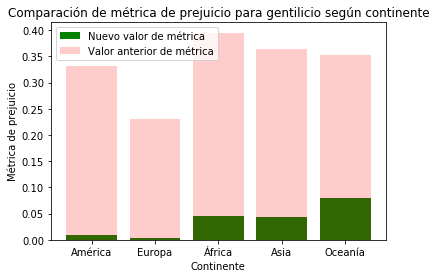

In [88]:
plt.bar(new_prejudge_demonym.keys(), new_prejudge_demonym.values(), color="green")
plt.bar(demonym_prejudge.keys(), demonym_prejudge.values(), color="red", alpha=0.2)
plt.legend(["Nuevo valor de métrica", "Valor anterior de métrica"])
plt.xlabel("Continente")
plt.ylabel("Métrica de prejuicio")
plt.title("Comparación de métrica de prejuicio para gentilicio según continente")

Así, efectivamente hay una reducción del prejuicio (al menos en la forma en que fue cuantificado en este informe) tras el cambio en los *embeddings* asociados a gentilicios y países. Ahora, quiere evaluarse los valores de prejuicio para la frase "Let's go get {gentilicio} food".

In [89]:
food_american_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, american_food_sentence)]
food_european_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, european_food_sentence)]
food_african_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, african_food_sentence)]
food_asian_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, asian_food_sentence)]
food_oceanian_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, oceanian_food_sentence)]

In [90]:
food_prejudge = {
    "América": np.array(food_american_prejudge).mean(),
    "Europa": np.array(food_european_prejudge).mean(),
    "África": np.array(food_african_prejudge).mean(),
    "Asia": np.array(food_asian_prejudge).mean(),
    "Oceanía": np.array(food_oceanian_prejudge).mean(),
}

In [91]:
new_food_american_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                         map(prepare_sentence_prejudge_free, american_food_sentence)]
new_food_european_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, european_food_sentence)]
new_food_african_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, african_food_sentence)]
new_food_asian_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, asian_food_sentence)]
new_food_oceanian_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, oceanian_food_sentence)]

In [92]:
new_food_prejudge = {
    "América": np.array(new_food_american_prejudge).mean(),
    "Europa": np.array(new_food_european_prejudge).mean(),
    "África": np.array(new_food_african_prejudge).mean(),
    "Asia": np.array(new_food_asian_prejudge).mean(),
    "Oceanía": np.array(new_food_oceanian_prejudge).mean(),
}

Text(0.5,1,"Comparación de métrica de prejuicio para 'Let's go get {} food' según continente")

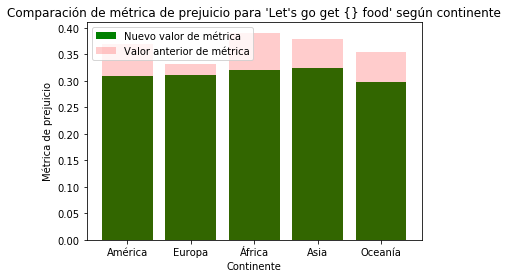

In [93]:
plt.bar(new_food_prejudge.keys(), new_food_prejudge.values(), color="green")
plt.bar(food_prejudge.keys(), food_prejudge.values(), color="red", alpha=0.2)
plt.legend(["Nuevo valor de métrica", "Valor anterior de métrica"])
plt.xlabel("Continente")
plt.ylabel("Métrica de prejuicio")
plt.title("Comparación de métrica de prejuicio para 'Let's go get {} food' según continente")

El gráfico indica que también hubo una reducción del prejuicio medido, pero la diferencia no es tan notoria como en el caso de los prejuicios por sí solos, como en el gráfico anterior. Finalmente, se quiso cuantificar el prejuicio para "Let's go to {país}".

In [94]:
american_places_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, american_places_sentence)]
european_places_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, european_places_sentence)]
african_places_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, african_places_sentence)]
asian_places_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, asian_places_sentence)]
oceanian_places_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence, oceanian_places_sentence)]

In [95]:
places_prejudge = {
    "América": np.array(american_places_prejudge).mean(),
    "Europa": np.array(european_places_prejudge).mean(),
    "África": np.array(african_places_prejudge).mean(),
    "Asia": np.array(asian_places_prejudge).mean(),
    "Oceanía": np.array(oceanian_places_prejudge).mean(),
}

In [96]:
new_american_places_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, american_places_sentence)]
new_european_places_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, european_places_sentence)]
new_african_places_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, african_places_sentence)]
new_asian_places_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, asian_places_sentence)]
new_oceanian_places_prejudge = [get_prejudge_metric(vector, test_svm) for vector in 
                     map(prepare_sentence_prejudge_free, oceanian_places_sentence)]

In [97]:
new_places_prejudge = {
    "América": np.array(new_american_places_prejudge).mean(),
    "Europa": np.array(new_european_places_prejudge).mean(),
    "África": np.array(new_african_places_prejudge).mean(),
    "Asia": np.array(new_asian_places_prejudge).mean(),
    "Oceanía": np.array(new_oceanian_places_prejudge).mean(),
}

Text(0.5,1,"Comparación de métrica de prejuicio para 'Let's go to {}' según continente")

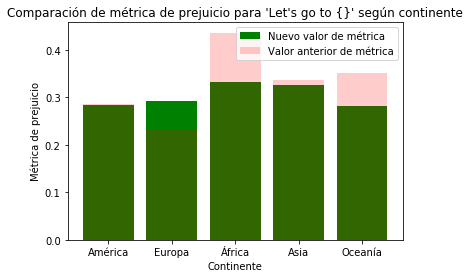

In [98]:
plt.bar(new_places_prejudge.keys(), new_places_prejudge.values(), color="green")
plt.bar(places_prejudge.keys(), places_prejudge.values(), color="red", alpha=0.2)
plt.legend(["Nuevo valor de métrica", "Valor anterior de métrica"])
plt.xlabel("Continente")
plt.ylabel("Métrica de prejuicio")
plt.title("Comparación de métrica de prejuicio para 'Let's go to {}' según continente")

El gráfico permite observar que el prejuicio medido se redujo de forma considerable en el caso de África, que era el continente más perjudicado. También se observan disminuciones para América, Asia y Oceanía, aunque menos marcadas. Se observa además un pequeño aumento en el caso de Europa. Esto es positivo, puesto que el nuevo valor es más similar al del resto de los continentes que el anterior. Finalmente, este era el objetivo a perseguir: que el sentimiento asociado a países y sus gentilicios fuera lo más neutro posible. Los valores más uniformes y disminuidos de la métrica de prejuicio en comparación a los primeros *outputs* del modelo, permiten afirmar que lo expuesto en este informe es un primer paso para no propagar (o, al menos, mitigar) terribles sesgos humanos en el área de aprendizaje de máquina.